# Numerical Integration

Differential equations describe the relation between an unknown function and its
derivatives. To solve a differential equation is to find a function that
satisfies the relation, typically while satisfying some additional conditions as
well. In this course we will be concerned primarily with a particular class of
problems, called initial value problems. In a canonical initial value problem,
the behavior of the system is described by an ordinary differential equation
(ODE) of the form

\begin{equation}
  \dot{{\bf x}} = f({\bf x}, t)
\end{equation}

where f is a known function ${\bf x}$ is the state of the system, and $\dot{{\bf
x}}$ is ${\bf x}$’s time derivative. Typically, ${\bf x}$ and $\dot{{\bf x}}$
are vectors. As the name suggests, in an initial value problem we are given
${\bf x}(t_0)= {\bf x_0}$ at some starting time $t_0$, and wish to follow ${\bf
x}$ over time thereafter.

In [2]:
#For widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox, Layout
from ipywidgets import FloatSlider, IntSlider,interactive_output
import ipywidgets as widgets
from IPython.display import display


# python packages and configurations
# %matplotlib nbagg
%matplotlib inline
from random import uniform
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
# plt.style.use('grayscale')
from scipy.integrate import odeint
from IPython.display import HTML, Video



# utility function
def visualize(t, y, u, analytical_solution):
    t = np.array(t)
    y = np.array(y)
    u = np.array(u)
    fig = plt.figure(figsize=(12, 6))
    ax = fig.subplots(1, 2)
    ax[0].plot(t, analytical_solution(t).real, label='analytical')
    ax[0].plot(t, y, 'x', label='numerical')
    ax[0].set_xlabel('$t (s)$')
    ax[0].set_ylabel('$y (m)$')
    ax[0].set_title('Solution')
    ax[0].legend()
    ax[1].quiver(y[:-1], u[:-1], y[1:] - y[:-1], u[1:] - u[:-1],
                 scale_units='xy', angles='xy', scale=1)
    ax[1].set_xlabel('$y (m)$')
    ax[1].set_ylabel('$u (m / s)$')
    ax[1].set_title('State-space')
    
    
def display_with_widgets(solver_function):
    dumping_slider  = FloatSlider(min=0, max=5, step=0.5, value=0,  description='dumping(d)', continuous_update=False, layout=Layout(width='420px'))
    dt_slider       = FloatSlider(min=0.01, max=1, step=0.01, value=0.1,  description='time_step(dt)', continuous_update=False, layout=Layout(width='420px'))
    mass_slider     = FloatSlider(min=0.05, max=10, step=0.1, value=1,   description='mass(m)', continuous_update=False, layout=Layout(width='420px'))
    stiffnes_slider = FloatSlider(min=0.05, max=20, step=0.5, value=5,  description='stiffness(k)',  continuous_update=False, layout=Layout(width='420px'))
    left_box  = VBox([dumping_slider, dt_slider])
    right_box = VBox([mass_slider, stiffnes_slider])
    ui = widgets.HBox([left_box, right_box])

    out = widgets.interactive_output(solver_function, {'d': dumping_slider, 'dt': dt_slider, 'm': mass_slider, "k" : stiffnes_slider})
    display(ui, out)

## Analytical Solution

Let us examine the following second-order ODE that represents a
mass-spring-damper system:

\begin{equation}
  m y'' + d y' + k y =0,\; y(t_0) = y_0, y'(t_0) = u_0
\end{equation}

where $m$, $d$ and $k$ are the mass, spring constant and damping coefficient,
respectively. The analytical solution of this equation is of the following form:

\begin{equation}
  y(t) = A e^{r_1 t} + B e^{r_2 t}
\end{equation}

where $r_1$ and $r_2$ are the roots of the homogeneous equation. Constants $A$
and $B$ are determined such as that the above equation satisfies the initial
conditions.

In [3]:
#Initial conditions
y0 = -5.0 # initial position 
u0 = 0.0  # initial velocity
end_time = 15

def calculate_analytical_solution(m, k, d, y0, u0):
    # find the roots of the homogeneous equation
    roots = sp.solve('m * y**2 + d * y + k', 'y')

    # find the constants of the analytical solution
    constants = sp.solve(['A + B - y0', 'r1 * A + r2 * B - u0'], 'A', 'B')

    # substitute the parameters 
    parameters = {'m': m, 'd': d, 'k': k}
    r1 = roots[0].subs(parameters)
    r2 = roots[1].subs(parameters)
    parameters['r1'] = r1
    parameters['r2'] = r2
    parameters['y0'] = y0
    parameters['u0'] = u0
    A = constants[sp.symbols('A')].subs(parameters)
    B = constants[sp.symbols('B')].subs(parameters)

    # calculate the analytical solution as a function of time
    t = sp.symbols('t')
    solution = sp.lambdify(t, A * sp.exp(r1 * t) + B * sp.exp(r2 * t))
    return solution

## Explicit Euler

The simplest numerical method is called explicit Euler. This method computes the
next value of the solution $x(t + dt)$ by taking a step in the derivative
direction

\begin{equation}
  x(t_0 + dt) = x(t_0) + x'(t_0) dt + O(dt^2)
\end{equation}

where $x'(t_0)$ is the first derivative valuated at $t_0$ and $dt$ is the step
size. This is a first-order approximation of the Taylor series. To solve a
second order differential equation, one can apply the Euler method
twice. Assuming that $u(t) = y'(t)$ and $a(t) = y''(t)$ then the problem is
expressed as follows:

\begin{aligned}
   a(t_0) &= -\frac{k}{m} y(t_0) - \frac{d}{m} u(t_0) \\
   u(t_0 + dt) &= u(t_0) + a(t_0) dt \\
   y(t_0 + dt) &= y(t_0) + u(t_0) dt.
\end{aligned}

In [7]:
def solve_euler(d, dt, m, k):
    # solution vectors
    t = [0.0]
    y = [y0]
    u = [u0]

    # numerical integration
    while t[-1] < end_time:
        t0 = t[-1]
        y_t0 = y[-1]
        u_t0 = u[-1]

        #TASK calculate a, u and y ####
        a_t0 =  -k/m*y_t0-d/m*u_t0
        u_t0_dt = u_t0 + a_t0*dt
        y_t0_dt = y_t0 + u_t0*dt 
        ###############################


        u.append(u_t0_dt)
        y.append(y_t0_dt)
        t.append(t0 + dt)
        
    #recalculate the analytical solution (global variable) for the new parameters
    analytical_solution = calculate_analytical_solution(m, k, d, y0, u0)
    
    # visualization
    visualize(t, y, u, analytical_solution)

    
# visualization with sliders
display_with_widgets(solve_euler)

Output()

## Tasks/Questions
1. Calculate a_t0, u_t0_dt, y_t0_dt.
2. Experiment with different spring parameters.
3. Is the system stable?
3. What would the state-space graph of the analytical solution look like?
4. Why does the numerical solution diverge from the true solution?
5. What can you do to better approximate the actual solution with this method?

## Semi-implicit Euler

The difference with the standard Euler method is that the semi-implicit Euler
method uses $u(t_0 + dt)$ in the equation for $y(t_0 + dt)$, while the Euler
method uses $u(t_0)$

\begin{aligned}
   a(t_0) &= -\frac{k}{m} y(t_0) - \frac{d}{m} u(t_0) \\
   u(t_0 + dt) &= u(t_0) + a(t_0) dt \\
   y(t_0 + dt) &= y(t_0) + u(t_0 + dt) dt.
\end{aligned}

In [10]:
def solve_semi_implicit_euler(d, dt, m, k):
    # solution vectors
    t = [0]
    y = [y0]
    u = [u0]

    # numerical integration
    while t[-1] < end_time:
        t0 = t[-1]
        y_t0 = y[-1]
        u_t0 = u[-1]  

        #TASK calculate a, u and y ####
        a_t0 = -k/m*y_t0-d/m*u_t0
        u_t0_dt = u_t0 + a_t0*dt
        y_t0_dt = y_t0 + u_t0_dt*dt 
        ###############################

        y.append(y_t0_dt)
        u.append(u_t0_dt)
        t.append(t0 + dt)

    #recalculate the analytical solution (global variable) for the new parameters
    analytical_solution = calculate_analytical_solution(m, k, d, y0, u0)

    # visualization
    visualize(t, y, u, analytical_solution)
display_with_widgets(solve_semi_implicit_euler)

Output()

## Tasks/Questions
1. Calculate a_t0, u_t0_dt, y_t0_dt.

1. Is this method stable and when? Compare it to the previous method both in stability and computational expense.
2. Can you explain intuitively why this method is more stable or unstable than the explicit Euler?
2. What about the accuracy of the obtained solution?

## The Midpoint Method and the Runge-Kutta method of Order 4

If we were able to evaluate $\ddot{{\bf x}}$ as well as $\dot{{\bf x}}$, we
could acheive $O(dt^3)$ accuracy instead of $O(dt^2)$ simply by retaining one
additional term in the truncated Taylor series:

\begin{equation}
   {\bf x}(t_0 + dt) = {\bf x}(t_0) + \dot{{\bf x}}(t_0) dt + \ddot{{\bf x}}(t_0) \frac{dt^2}{2} + O(dt^3).  \quad \quad (1)
\end{equation}

Recall that the time derivative $\dot{{\bf x}}$ is given by a function $f({\bf
x}(t), t)$. For simplicity in what follows, we will assume that the derivative
function $f$ does depends on time only indirectly through ${\bf x}$, so that
$\dot{{\bf x}} = f({\bf x}(t))$. The chain rule then gives


\begin{equation}
   \ddot{{\bf x}} = \frac{df}{d {\bf x}} \dot{{\bf x}} = f' f.
\end{equation}

To avoid having to evaluate $f'$, which would often be complicated and
expensive, we can approximate the second-order term just in terms of $f$, and
substitute the approximation into Eq. (1), leaving us with $O(dt^3)$ error. To
do this, we perform another Taylor expansion, this time of the function of $f$

\begin{equation}
   f({\bf x}_0 + \Delta {\bf x}) = f({\bf x}_0) + f'({\bf x}_0) \Delta {\bf x} + O(\Delta {\bf x}^2).
\end{equation}

We first induce $\ddot{{\bf x}}$ into this expression by choosing

\begin{equation}
  \Delta {\bf x} = f({\bf x}_0) \frac{dt}{2}
\end{equation}

so that

\begin{equation}
   f({\bf x}_0 + f({\bf x}_0) \frac{dt}{2}) = f({\bf x}_0) + f'({\bf x}_0) f({\bf x}_0) \frac{dt}{2} + O(dt^2) = f({\bf x}_0) + \ddot{{\bf x}}(t_0) \frac{dt}{2} + O(dt^2)
\end{equation}

where ${\bf x}_0 = {\bf x}(t_0)$. We can now multiply both sides by $dt$
(turning the $O(dt^2)$ term into $O(dt^3)$) and rearrange, yielding

\begin{equation}
  \ddot{{\bf x}}(t_0) \frac{dt^2}{2} + O(dt^3) = (f({\bf x}_0 + f({\bf x}_0) \frac{dt}{2}) - f({\bf x}_0)) dt
\end{equation}

Substituting the right hand side into Eq. (1) gives the update formula

\begin{equation}
   {\bf x}(t_0 + dt) = {\bf x}(t_0) + f({\bf x}_0 + f({\bf x}_0) \frac{dt}{2}) dt
\end{equation}

This formula first evaluates an Euler step, then performs a second derivative
evaluation at the midpoint of the step, using the midpoint evaluation to update
${\bf x}$. Hence the name midpoint method. The midpoint method is correct to
within $O(dt^3)$, but requires two evaluations of $f$.

We don’t have to stop with an error of $O(dt^3)$. By evaluating $f$ a few more
times, we can eliminate higher and higher orders of derivatives. The most
popular procedure for doing this is a method called Runge-Kutta of order 4 and
has an error per step of $O(dt^4)$ (the midpoint method could be called
Runge-Kutta of order 2). We won’t derive the fourth order Runge-Kutta method,
but the formula for computing ${\bf x}(t_0 + dt)$ is listed below:

\begin{aligned}
    k_1 &= f({\bf x}_0, t_0) dt \\
    k_2 &= f({\bf x}_0 + \frac{k_1}{2}, t_0 + \frac{dt}{2}) dt \\
    k_3 &= f({\bf x}_0 + \frac{k_2}{2}, t_0 + \frac{dt}{2}) dt \\
    k_4 &= f({\bf x}_0 + k_3, t_0 + dt) dt \\
    {\bf x}(t_0 + dt) &= {\bf x}_0 + \frac{1}{6} (k_1 + 2 k_2 + 2 k_3 + k_4).
\end{aligned}

In order to express the second-order ODE into a cannonical first-order form

\begin{equation}
  \dot{{\bf x}} = f({\bf x}, t)
\end{equation}


one can use the following transformation $x_1 = y$, $x_2 = y'$, $x_1' = x_2$ and $x_2' = y''$. Therefore, the transformed system of equations becomes:

\begin{equation}
  \bf x = \begin{bmatrix}
    x_1 \\ x_2
  \end{bmatrix} = 
  \begin{bmatrix}
    y \\ u
  \end{bmatrix}
\end{equation}



\begin{equation}
  \dot{{\bf x}} =
  \begin{bmatrix}
    \dot{x}_1 \\ \dot{x}_2 
  \end{bmatrix} = 
  \begin{bmatrix}
    u \\ a
  \end{bmatrix} =
  \begin{bmatrix} 
    x_2 \\ - \frac{k}{m} x_1 - \frac{d}{m} x_2 
  \end{bmatrix} =
  f({\bf x}, t).
\end{equation}

A more visual presentation of the k variables and what they mean is shown here
![title](rk4.png)

In [12]:
def runge_kutta_solver(d, dt, m, k):
    t = [0]
    x = [[y0, u0]]

    # first-order derivative function
    def f(x, t):
        return np.array([x[1], -k / m * x[0] - d / m * x[1]])

    # numerical integration
    while t[-1] < end_time:
        t0 = t[-1]
        x_t0 = np.array(x[-1])

        #Calculate k1, k2, k3, k4 and finally x_t0_dt
        k1 = f(x_t0,t0)*dt
        k2 = f(x_t0+k1/2,t0+dt/2)*dt
        k3 = f(x_t0+k2/2,t0+dt/2)*dt
        k4 = f(x_t0+k3,t0+dt)*dt
        x_t0_dt = x_t0 + 1/6*(k1+2*k2+2*k3+k4) 
       
        ###############################################

        x.append(x_t0_dt)    
        t.append(t0 + dt)

    analytical_solution = calculate_analytical_solution(m, k, d, y0, u0)
    # visualization
    x = np.array(x)
    visualize(t, x[:, 0], x[:, 1],analytical_solution)
    
display_with_widgets(runge_kutta_solver)

Output()

## Tasks/Questions

1. Can you lead the system to instability and how does its resilience compared to the previous methods? Also compare this method in terms of computational cost.
1. What is the error of this method?
2. Do you expect the solution to diverge and if yes, when?

## Adaptive Time Stepping

Whatever the underlying method, a major problem lies in determing a good stepsize. Ideally, we
want to choose h as large as possible—but not so large as to give us an unreasonable amount of
error, or worse still, to induce instability. If we choose a fixed stepsize, we can only proceed as
fast as the “worst” sections of x(t) will allow.

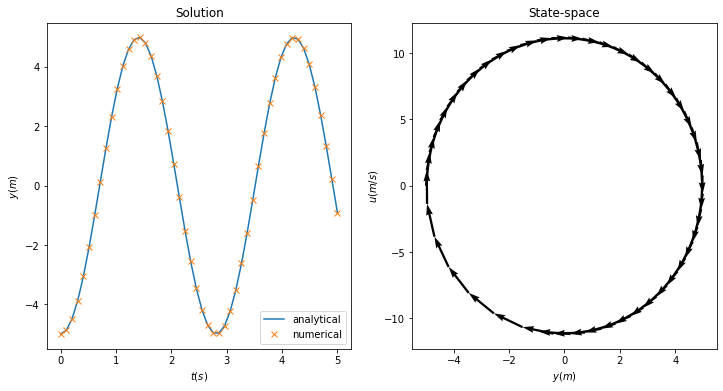

In [19]:
# integration parameters
# model parameters and initial conditions
m = 1.0   # mass
k = 5.0   # spring constant
d = 0.0   # damping coefficient
y0 = -5.0 # initial position 
u0 = 0.0  # initial velocity
end_time = 5
t = np.linspace(0, end_time/1, end_time * 10)

x0 = [y0, u0]

# first-order derivative function
def f(x, t):
    return [x[1], -k / m * x[0] - d / m * x[1]]
    
# numerical integration
[x, infodict] = odeint(f, x0, t, full_output=True)

# visualization
analytical_solution = calculate_analytical_solution(m, k, d, y0, u0)
visualize(t, x[:, 0], x[:, 1], analytical_solution)
#print(len(infodict['tcur']))
#print(len(t))

## Tasks/Questions

1. Change the density of the time points in np.linspace. What do you observe? (This time you have to manually change values and rerun the block)
2. Do you expect the solution to diverge?
3. Which algorithms are supported by odeint?

## Cloth Simulation

In [4]:
# topology
W = 1.0  # grid width
H = 1.0  # grid heigh
particles_x = 11  # number of particles on x-axis
particles_y = 11  # number of particles on y-axis
# l is the spring rest lenght (x-axis, y-axis, xy: diagonal)
# type-1 (+-1, +-1) or type-2 (+-2, +-2) refers to the connectivity 
lx_type1 = W / (particles_x - 1)
ly_type1 = H / (particles_y - 1)
lxy_type1 = np.sqrt(lx_type1 ** 2 + ly_type1 ** 2)
lx_type2 = 2 * lx_type1
ly_type2 = 2 * ly_type1
lxy_type2 = 2 * lxy_type1
indices = [(i, j) for i in range(0, particles_y) for j in range(0, particles_x)]

def cartesian_product(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = int(n / arrays[0].size)
    out[:, 0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian_product(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
            out[j * m:(j + 1) * m, 1:] = out[0:m, 1:]
    
    return out

def is_valid_coordinate(i, j):
    if i < 0 or i >= particles_y or j < 0 or j >= particles_x:
        return False
    else: 
        return True
    
def append_connectivity_if_valid(i, j, i_inc, j_inc, connectivity):
    if is_valid_coordinate(i + i_inc, j + j_inc):
        connectivity[i, j].append((i + i_inc, j + j_inc))
        
def generate_connectivity(indices, combinations):
    permutations = tuple(map(tuple, cartesian_product(combinations)))
    permutations = list(set(permutations))  # to remove duplicate combinations
    permutations.remove((0, 0))  # to remove identity
    connectivity = {}
    for i, j in indices:
        connectivity[i, j] = []
        for i_inc, j_inc in permutations:
            append_connectivity_if_valid(i, j, i_inc, j_inc, connectivity)
    
    return connectivity

# define type-1 and type-2 connectivity    
type1_connectivity = generate_connectivity(indices, ([1, 0, -1], [1, 0, -1]))
type2_connectivity = generate_connectivity(indices, ([2, 0, -2], [2, 0, -2]))      

7.867479126514021


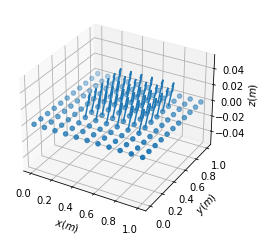

In [5]:
# initial state variables
u0 = uniform(5, 10)
print(u0)
X0 = np.zeros((particles_y, particles_x, 3))
U0 = np.zeros((particles_y, particles_x, 3)) 

# initialize particle state (position and velocity)
for i, j in indices:
    X0[i, j, :] = np.array([i * H / (particles_y - 1), 
                            j * W / (particles_x - 1), 0])
    
    # particles that have initial velocity
    if j > 2 and j < particles_x - 2 and i > 2 and i < particles_y - 2:
        U0[i, j, :] = np.array([u0, u0, u0])
        
    # make sure that upper part particles have zero initial velocity 
    # since they are assumed fixed
    for i in range(0, particles_y):
        U0[i, particles_x - 1, :] = np.array([0, 0, 0])

# visualize initial conditions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('$x (m)$')
ax.set_ylabel('$y (m)$')
ax.set_zlabel('$z (m)$')
ax.scatter(X0[:, :, 0], X0[:, :, 1], X0[:, :, 2])
ax.quiver(X0[:, :, 0], X0[:, :, 1], X0[:, :, 2],
          U0[:, :, 0], U0[:, :, 1], U0[:, :, 2],
          length=0.05, normalize=True)

In [6]:
total_cloth_mass = 3.0
m = total_cloth_mass / (particles_x * particles_y)  # particle mass
k = 10.0
d = 0.05
g = 9.8
def calc_total_force(i, j, X_n, U_n):
    f_ij = np.array([0 ,0, 0])
    
    # type-1 internal forces
    for i_n, j_n in type1_connectivity[i, j]:
        x_ij = X_n[i_n, j_n, :] - X_n[i, j, :]
        x_ij_mag = np.linalg.norm(x_ij)
        
        #calculate resting length
        l = 0
        if np.abs(i - i_n) > 0 and np.abs(j - j_n) > 0:
            l = lxy_type1
        elif np.abs(i - i_n) > 0 and not np.abs(j - j_n) > 0:
            l = ly_type1
        else:
            l = lx_type1
            
        # spring force only during elongation 
        if x_ij_mag - l >= 0:
            f_ij = f_ij + k * (x_ij_mag - l) * x_ij / x_ij_mag
            
        # damping force
        f_ij = f_ij - d * (U_n[i, j, :] - U_n[i_n, j_n, :])
        
    # other types of internal forces can be implemented for type-2
    for i_n, j_n in type2_connectivity[i, j]:
        x_ij = X_n[i_n, j_n, :] - X_n[i, j, :]
        x_ij_mag = np.linalg.norm(x_ij)
        l = 0
        if np.abs(i - i_n) > 0 and np.abs(j - j_n) > 0:
            l = lxy_type2
        elif np.abs(i - i_n) > 0 and not np.abs(j - j_n) > 0:
            l = ly_type2
        else:
            l = lx_type2
            
        # spring force only during elongation
        if x_ij_mag - l >= 0:
            f_ij = f_ij + k * (x_ij_mag - l) * x_ij / x_ij_mag
            
        # damping force
        f_ij = f_ij - d * (U_n[i, j, :] - U_n[i_n, j_n, :])
                         
    return f_ij
  

def calc_acceleration(X_t0, U_t0):
    A_t0 = np.zeros((particles_y, particles_x, 3))
    for i, j in indices:
        A_t0[i, j, :] = 1.0 / m * calc_total_force(i, j, X_t0, U_t0) \
                        + np.array([0, -g, 0])
        
    # upper part particles are fixed, therefore ensure zeor acceleration
    for i in range(0, particles_y):
        A_t0[i, particles_x - 1, :] = np.array([0, 0, 0])
        
    return A_t0

In [7]:
# integration parameters
end_time = 10
dt = 0.01

# solution vectors
t = [0]
X = [X0]
U = [U0]

# numerical integration (Semi-implicit Euler)
while t[-1] < end_time:
    t_0 = t[-1]
    X_t0 = X[-1]
    U_t0 = U[-1] 
    A_t0 = calc_acceleration(X_t0, U_t0)
    U_t0_dt = U_t0 + A_t0 * dt
    X_t0_dt = X_t0 + U_t0_dt * dt
    t.append(t_0 + dt)
    X.append(X_t0_dt)
    U.append(U_t0_dt)

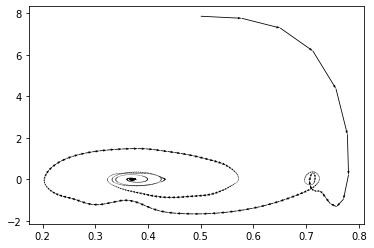

In [8]:
# select particle and coordinate variable to visualize the state space. This just follows one particle of the
# whole system, but it can give useful insight.
particle_i = 5
particle_j = 5
axis = 1  # 0, 1, 2 for x, y, z
X_p = np.array(X)[:, particle_i, particle_j, axis] 
U_p = np.array(U)[:, particle_i, particle_j, axis]

# create state-space diagram
fig, ax = plt.subplots()
ax.quiver(X_p[:-1], U_p[:-1], 
          X_p[1:] - X_p[:-1], 
          U_p[1:] - U_p[:-1], 
          scale_units='xy', angles='xy', scale=1)

In [9]:
#This part is complately optinal and is used to better view the simulation of the cloth, not being able to
#run this code is ok
import sys
import time

sys.path.append('pythonGL/')
import opengl
import pygame


opengl.init()
for i in range(0, len(X[:])):
    (verts,norms, uvs) = opengl.create_list_of_vertices(X[i])
    opengl.draw(verts, norms, uvs)
    for event in pygame.event.get():
            if event.type == pygame.QUIT:
                opengl.closeAll()
    time.sleep(1*dt)


pygame 2.0.1 (SDL 2.0.14, Python 3.9.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Tasks/Questions


1. There will be no code-writting in this part, but plase take your time and understand the code, it is just a mass-spring system on a large scale and a useful application of what we discussed so far.
2. Tweak the values of the simulation (force, k, d, etc...) and break the system. What value was the most effective to lead the system to instability?

In [10]:
#If the python opengl block (the one above) does not work or gives weird errors, change save_to_video to True
#and run this block

save_to_video = False
if save_to_video:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    title = ax.set_title('')
    ax.set_xlabel('$x (m)$')
    ax.set_ylabel('$y (m)$')
    ax.set_zlabel('$z (m)$')
    ax.set_xlim([-0.5, W + 0.5])
    ax.set_ylim([-0.5, W + 0.5])
    ax.set_zlim([-0.5, 0.5])
    graph, = ax.plot([], [], [], linestyle='', marker='o')

    # animation update function
    def update_graph(i):
        graph.set_data(X[i][:, :, 0].reshape(-1), X[i][:, :, 1].reshape(-1))
        graph.set_3d_properties(X[i][:, :, 2].reshape(-1))
        title.set_text('time={:.2f}'.format(t[i]))
        return graph, title, 

    # create animation; blit=True means only re-draw the parts that have changed
    anim = animation.FuncAnimation(fig, update_graph, 
                                   frames=len(X), interval=30, blit=True)
    anim.save('simulation.mp4', writer="ffmpeg")
    plt.close()
    # HTML(anim.to_html5_video())
    Video("simulation.mp4")